In [ ]:
import os
import h5py
import math
import numpy as np
import pandas as pd
import glob
import json
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Add, Dense, MaxPool2D,Activation, ZeroPadding2D, GlobalAveragePooling2D,BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from tensorflow.keras.utils import plot_model
from tensorflow.keras.initializers import glorot_uniform
import scipy.misc
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
%matplotlib inline
import tensorflow.keras.backend as K
# Image dataset has channels as its last dimensions
K.set_image_data_format('channels_last')

In [ ]:
#Importing library tensorflow to operate on model

import tensorflow_datasets as tfds
import keras, os
import numpy as np
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt

from tensorflow.python.util import deprecation
from tensorflow.keras import backend
from tensorflow.keras.applications.resnet50 import preprocess_input


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from tensorflow.keras.models import load_model

In [ ]:
pip install scikit-multilearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#Mounting Google drive 

from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
###Preparing dictionary for image labels 

label_map = {0:'Normal', 
             1:'Atelectasis',
             2:'Calcification', 
             3:'Consolidation', 
             4:'Effusion', 
             5:'Emphysema', 
             6:'Fibrosis', 
             7:'Fracture', 
             8:'Mass', 
             9: 'Nodule', 
             10:'Pneumothorax'}

rev_label_map = {v: k for k, v in label_map.items()}

In [ ]:
###Mapping the train dataset labels with index and classes

##For mapping, we use json file of labels that were a part of our dataset

#In these steps, we first created a dataframe of train labels from json file and then created an array of those labels called y_train


with open('/content/drive/MyDrive/train.json') as user_file:
    file_contents = user_file.read()
parsed_json = json.loads(file_contents)

class_list = []
file_list = []
for i in parsed_json:
    class_list.append(list(set(i['syms'])))
    file_list.append(i['file_name'])

for i in class_list:
    if len(i)==0:
        i.append(label_map[0])


df = pd.DataFrame(data=class_list)
df['label'] = pd.Series(class_list)
df = df['label']
df_process = pd.get_dummies(df.apply(pd.Series).stack()).sum(level=0)
df_process['file_name'] = pd.Series(file_list)
df_clean=df_process.drop('file_name',axis = 1)
y_train = np.array(df_clean)
len(y_train)

<ipython-input-20-7fc2b8502d92>:26: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  df_process = pd.get_dummies(df.apply(pd.Series).stack()).sum(level=0)


3001

In [ ]:
#Depiction of how the array of labels look like 

y_train[:10] 

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0]], dtype=uint8)

In [ ]:
###Mapping the test dataset labels with index and classes

##For mapping, we use json file of labels that were a part of our dataset

#In these steps, we first created a dataframe of test labels from json file and then created an array of those labels called y_test 

with open('/content/drive/MyDrive/test.json') as user_file:
    file_contents = user_file.read()
parsed_test_json = json.loads(file_contents)

test_class_list = []
test_file_list = []
for i in parsed_test_json:
    test_class_list.append(list(set(i['syms'])))
    test_file_list.append(i['file_name'])


for i in test_class_list:
    if len(i)==0:
        i.append(label_map[0])

test_df = pd.DataFrame(data=test_class_list)
test_df['label'] = pd.Series(test_class_list)
test_df = test_df['label']
test_df_process = pd.get_dummies(test_df.apply(pd.Series).stack()).sum(level=0)
test_df_process['file_name'] = pd.Series(test_file_list)
test_df_clean=test_df_process.drop('file_name',axis = 1)
y_test = np.array(test_df_clean)
len(y_test)

<ipython-input-18-e35d70279e09>:25: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  test_df_process = pd.get_dummies(test_df.apply(pd.Series).stack()).sum(level=0)


542

In [ ]:
#Depiction of how the array of labels look like 

y_test[:10] 

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]], dtype=uint8)

In [ ]:
#We converted the .jpg images of test and train data into a numpy array file for the ease of processing in computer vision models 

train_data = np.load('/content/drive/MyDrive/xray/train_image.npy', encoding='bytes')
test_data = np.load('/content/drive/MyDrive/xray/test_image.npy', encoding='bytes')

In [ ]:
#Checking the shape of training data 

train_data.shape

(3001, 1024, 1024)

In [ ]:
#Checking the shape of testing data 

test_data.shape

(542, 1024, 1024)

In [ ]:
#Reshaping the training dataset to reduce their size from 1024 to 224 and from 3-dimensional to 4-dimensional 

train_new = np.zeros((3001, 300, 300, 1))
for i in range(3001):
  train_new[i] = np.reshape(cv2.resize(train_data[i], (300,300)), (300,300,1))

In [ ]:
#Checking new shape of training dataset 

train_new.shape

(3001, 300, 300, 1)

In [ ]:
#Reshaping the testing dataset to reduce their size from 1024 to 224 and from 3-dimensional to 4-dimensional 

test_new = np.zeros((542,  300, 300, 1))
for i in range(542):
  test_new[i] = np.reshape(cv2.resize(test_data[i], (300,300)), (300,300,1))

In [ ]:
#Checking new shape of testing dataset 

test_new.shape

(542, 300, 300, 1)

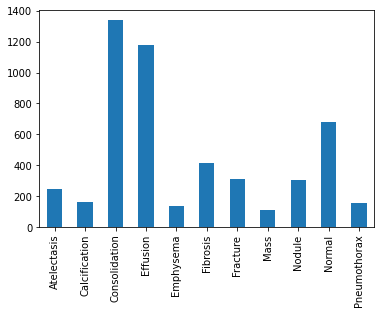

In [ ]:
#Visualize training data label imbalances
df_train_sum = df_clean.sum(axis=0)
df_train_sum.plot(kind='bar')

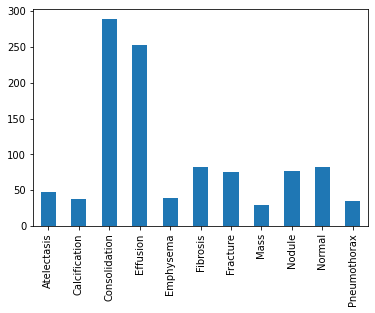

In [ ]:
#Visualize testing data label imbalances
df_test_sum = test_df_clean.sum(axis=0)
df_test_sum.plot(kind='bar')

In [ ]:
#Stratifying data while splitting train and validation data
from skmultilearn.model_selection import iterative_train_test_split
X_train, y_train, X_val, y_val = iterative_train_test_split(train_new, y_train, test_size = 0.1)

In [ ]:
#Setting up resnet blocks and rsnet model
class ResnetBlock(Model):
    """
    A standard resnet block.
    """

    def __init__(self, channels: int, down_sample=False):
        """
        channels: same as number of convolution kernels
        """
        super().__init__()

        self.__channels = channels
        self.__down_sample = down_sample
        self.__strides = [2, 1] if down_sample else [1, 1]

        KERNEL_SIZE = (3, 3)
        # use He initialization, instead of Xavier (a.k.a 'glorot_uniform' in Keras), as suggested in [2]
        INIT_SCHEME = "he_normal"

        self.conv_1 = Conv2D(self.__channels, strides=self.__strides[0],
                             kernel_size=KERNEL_SIZE, padding="same", kernel_initializer=INIT_SCHEME)
        self.bn_1 = BatchNormalization()
        self.conv_2 = Conv2D(self.__channels, strides=self.__strides[1],
                             kernel_size=KERNEL_SIZE, padding="same", kernel_initializer=INIT_SCHEME)
        self.bn_2 = BatchNormalization()
        self.merge = Add()

        if self.__down_sample:
            # perform down sampling using stride of 2, according to [1].
            self.res_conv = Conv2D(
                self.__channels, strides=2, kernel_size=(1, 1), kernel_initializer=INIT_SCHEME, padding="same")
            self.res_bn = BatchNormalization()

    def call(self, inputs):
        res = inputs

        x = self.conv_1(inputs)
        x = self.bn_1(x)
        x = tf.nn.relu(x)
        x = self.conv_2(x)
        x = self.bn_2(x)

        if self.__down_sample:
            res = self.res_conv(res)
            res = self.res_bn(res)

        # if not perform down sample, then add a shortcut directly
        x = self.merge([x, res])
        out = tf.nn.relu(x)
        return out


class ResNet18(Model):

    def __init__(self, num_classes, **kwargs):
        """
            num_classes: number of classes in specific classification task.
        """
        super().__init__(**kwargs)
        self.conv_1 = Conv2D(64, (7, 7), strides=2,
                             padding="same", kernel_initializer="he_normal")
        self.init_bn = BatchNormalization()
        self.pool_2 = MaxPool2D(pool_size=(2, 2), strides=2, padding="same")
        self.res_1_1 = ResnetBlock(64)
        self.res_1_2 = ResnetBlock(64)
        self.res_2_1 = ResnetBlock(128, down_sample=True)
        self.res_2_2 = ResnetBlock(128)
        self.res_3_1 = ResnetBlock(256, down_sample=True)
        self.res_3_2 = ResnetBlock(256)
        self.res_4_1 = ResnetBlock(512, down_sample=True)
        self.res_4_2 = ResnetBlock(512)
        self.avg_pool = GlobalAveragePooling2D()
        self.flat = Flatten()
        self.fc = Dense(num_classes, activation="sigmoid")

    def call(self, inputs):
        out = self.conv_1(inputs)
        out = self.init_bn(out)
        out = tf.nn.relu(out)
        out = self.pool_2(out)
        for res_block in [self.res_1_1, self.res_1_2, self.res_2_1, self.res_2_2, self.res_3_1, self.res_3_2, self.res_4_1, self.res_4_2]:
            out = res_block(out)
        out = self.avg_pool(out)
        out = self.flat(out)
        out = self.fc(out)
        return out

In [ ]:
#Setting up and compiling the model
model = ResNet18(11)
model.build(input_shape = (None,300,300,1))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[tf.keras.metrics.BinaryAccuracy(),tf.keras.metrics.AUC()])

Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [ ]:
# Normalizing and augmenting the data
aug = ImageDataGenerator(horizontal_flip=True, rotation_range=10, featurewise_center=True, featurewise_std_normalization=True,  fill_mode="nearest")
aug.fit(X_train)

In [ ]:
# Training Resnet18 model by feeding label dataset through "aug" for fitting the model to get training and validation accuracy per epoch

batch_size=32
model.fit(x=aug.flow(X_train, y_train, batch_size=32),validation_data=(X_val, y_val), steps_per_epoch = len(X_train)//batch_size, epochs = 10)


Epoch 1/10
84/84 [==============================] - 777s 9s/step - loss: 0.3835 - binary_accuracy: 0.8378 - auc_1: 0.7412 - val_loss: 2777.5527 - val_binary_accuracy: 0.6515 - val_auc_1: 0.6148
Epoch 2/10
84/84 [==============================] - 760s 9s/step - loss: 0.3683 - binary_accuracy: 0.8449 - auc_1: 0.7564 - val_loss: 236.2747 - val_binary_accuracy: 0.5079 - val_auc_1: 0.5708
Epoch 3/10
84/84 [==============================] - 768s 9s/step - loss: 0.3660 - binary_accuracy: 0.8460 - auc_1: 0.7588 - val_loss: 218.2800 - val_binary_accuracy: 0.4517 - val_auc_1: 0.3550
Epoch 4/10
84/84 [==============================] - 769s 9s/step - loss: 0.3664 - binary_accuracy: 0.8455 - auc_1: 0.7594 - val_loss: 980.7206 - val_binary_accuracy: 0.3488 - val_auc_1: 0.5040
Epoch 5/10
84/84 [==============================] - 773s 9s/step - loss: 0.3665 - binary_accuracy: 0.8439 - auc_1: 0.7596 - val_loss: 97.2294 - val_binary_accuracy: 0.4492 - val_auc_1: 0.4630
Epoch 6/10
84/84 [=================

In [ ]:
#Fetching probability predictions of each validation and testing images 
val_pred = model.predict(X_val)
np.save('/content/drive/MyDrive/res18_val_out_final.npy', val_pred)  

test_pred = model.predict(test_new)
np.save('/content/drive/MyDrive/res18_test_out_final.npy', test_pred)  

17/17 [==============================] - 36s 2s/step


In [ ]:
#Model Ending